In [ ]:
%%capture

import yfinance as yf
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from scipy.interpolate import RectBivariateSpline
from scipy.stats import norm
from datetime import timedelta
import os
from scipy.stats import t
import statsmodels.api as sm
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from scipy.interpolate import CubicSpline
from scipy.integrate import trapz

warnings.filterwarnings("ignore", category=DeprecationWarning)

# Восстановление распределения

In [ ]:
# Список файлов .txt в указанной папке

# folder_path = '/content/drive/My Drive/Диссертация/Data_test'

folder_path = '/content/drive/MyDrive/Диссертация/S_P_500_Options_data'

files = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.txt')]

In [ ]:
%%time

total_success_vertical_spread = 0
total_success_butterfly_spread = 0
total_success_calendar_spread = 0

dates = []
risk_neutral_std = []
risk_neutral_mean = []
risk_neutral_skewness = []
risk_neutral_kurtosis = []
recovered_std = []
recovered_mean = []
recovered_skewness = []
recovered_kurtosis = []
mean_error_percentage = []
option_per_day = []
unique_dates_count = []

# Цикл по всем файлам
for file in files:
  try:
    data = pd.read_csv(file, delimiter=',', low_memory=False)
    data.columns = data.columns.str.strip().str.replace(r'[\[\]]', '', regex=True)

    # Преобразовываем QUOTE_DATE в тип datetime
    data['QUOTE_DATE'] = pd.to_datetime(data['QUOTE_DATE'])
    data['EXPIRE_DATE'] = pd.to_datetime(data['EXPIRE_DATE'])

    # Получаем список всех уникальных дат QUOTE_DATE
    unique_dates = data['QUOTE_DATE'].dt.date.unique()
    unique_dates_count.append(len(unique_dates))

    # Цикл для каждой уникальной даты QUOTE_DATE в текущем файле
    for selected_date in unique_dates:
      selected_date = pd.to_datetime(selected_date)
      # Фильтруем данные для текущей даты
      data_one_day = data[data['QUOTE_DATE'] == selected_date].copy()
      # Вычисляем Tenor для текущей даты
      data_one_day['Tenor'] = ((data_one_day['EXPIRE_DATE'] - selected_date).dt.days / 365).round(2)

      C_IV_Matrix = data_one_day[['STRIKE', 'C_IV', 'Tenor']].copy()
      C_IV_Matrix['STRIKE'] = pd.to_numeric(C_IV_Matrix['STRIKE'], errors='coerce')
      C_IV_Matrix['C_IV'] = pd.to_numeric(C_IV_Matrix['C_IV'], errors='coerce')

      # Создаем сводную таблицу (pivot table), используя цены колл-опционов как значения
      C_IV_Matrix = C_IV_Matrix.pivot_table(values='C_IV', index='STRIKE', columns='Tenor').dropna(inplace=False)
      Tenor = [round((i + 1) / 12, 4) for i in range(12)]
      Strike_center = data_one_day['UNDERLYING_LAST'].iloc[0]
      # Определяем процентные изменения относительно центрального значения Strike
      percent_changes = np.arange(-30, 35, 5) / 100  # От -30% до +30% с шагом 5%
      Strike = Strike_center * (1 + percent_changes)
      vols_surface_empty = pd.DataFrame(index=Strike, columns=Tenor)

      ##################################### Интерполяция #####################################
      X = C_IV_Matrix.columns.astype(float)
      Y = C_IV_Matrix.index.astype(float)
      Z = C_IV_Matrix.values
      interp_func = RectBivariateSpline(Y, X, Z, kx=1, ky=1)
      empty_matrix_tenor = vols_surface_empty.columns.astype(float)
      empty_matrix_strike = vols_surface_empty.index.astype(float)
      interpolated_values = interp_func(empty_matrix_strike, empty_matrix_tenor, grid=True)
      vols_surface_interpolated = pd.DataFrame(interpolated_values, index=vols_surface_empty.index, columns=vols_surface_empty.columns)
      vols_surface_interpolated.index.name = 'Strike'
      vols_surface_interpolated.columns.name = 'Tenor'

      ##################################### Расчет цен опционов #####################################
      # Расчет цен Call опционов с интерполированной implied volatility
      def black_scholes_call(S, K, r, T, sigma):
          d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
          d2 = d1 - sigma * np.sqrt(T)
          call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
          return call_price

      # Процентная ставка теперь равна загруженной процентной ставке
      ticker = "^TNX"  # Тикер для 10-летних государственных облигаций
      start_date = selected_date - timedelta(days=7)
      end_date = selected_date
      interest_rate_data = yf.download(ticker, start=start_date, end=end_date, progress=False)
      r = interest_rate_data['Adj Close'].iloc[-1] / 100

      call_prices = pd.DataFrame(index=vols_surface_interpolated.index, columns=vols_surface_interpolated.columns)
      for tenor in vols_surface_interpolated.columns:
          for strike in vols_surface_interpolated.index:
              volatility = vols_surface_interpolated.loc[strike, tenor]
              call_prices.loc[strike, tenor] = black_scholes_call(data_one_day['UNDERLYING_LAST'].iloc[0], strike, r, tenor, volatility)

      ##################################### Проверка по спредам #####################################
      # Вертикальный
      vertical_spread_success_flag = False
      spread_value = pd.DataFrame(index=call_prices.index, columns=call_prices.columns)
      for i in range(len(call_prices.index) - 1):
          spread_value.iloc[i, :] = (call_prices.iloc[i, :] - call_prices.iloc[i + 1, :]) / (
                  call_prices.index[i + 1] - call_prices.index[i])
          spread_value = spread_value.fillna(0).astype(int)
          vertical_check = (spread_value >= 0) & (spread_value <= 1)

          if vertical_check.all().all() and not vertical_spread_success_flag:
              total_success_vertical_spread += 1
              vertical_spread_success_flag = True

      # Бабочка
      butterfly_spread_success_flag = False
      spread_value = pd.DataFrame(index=call_prices.index, columns=call_prices.columns)
      for i in range(1, len(call_prices) - 1):
          spread_value.iloc[i, :] = call_prices.iloc[i - 1, :] - (
              call_prices.iloc[i, :] * ((call_prices.index[i + 1] - call_prices.index[i - 1]) / (
                  call_prices.index[i + 1] - call_prices.index[i]))) + (
                                      call_prices.iloc[i + 1, :] * (
                                          (call_prices.index[i] - call_prices.index[i - 1]) / (
                                              call_prices.index[i + 1] - call_prices.index[i])))
          spread_value = spread_value.fillna(0).astype(int)
          butterfly_check = (spread_value >= 0)

          if butterfly_check.all().all() and not butterfly_spread_success_flag:
              total_success_butterfly_spread += 1
              butterfly_spread_success_flag = True

      # Календарный
      calendar_spread_success_flag = False
      spread_value = pd.DataFrame(index=call_prices.index, columns=call_prices.columns)
      for i in range(len(call_prices.columns) - 1):
          spread_value.iloc[:, i] = call_prices.iloc[:, i + 1] - call_prices.iloc[:, i]
          spread_value = spread_value.fillna(0).astype(int)
          calendar_check = (spread_value >= 0)

          if calendar_check.all().all() and not calendar_spread_success_flag:
              total_success_calendar_spread += 1
              calendar_spread_success_flag = True

      ##################################### State price matrix #####################################
      # Матрица state price из цен колл опционов по формуле Breeden-Litzenberg
      state_prices = pd.DataFrame(index=call_prices.index, columns=call_prices.columns)
      r = interest_rate_data['Adj Close'].iloc[-1] / 100

      for i in range(1, len(call_prices.index) - 1):
          for j in range(len(call_prices.columns)):
              state_prices.iloc[i, j] = np.exp(r * call_prices.columns[i]) * (
                  call_prices.iloc[i + 1, j] - 2 * call_prices.iloc[i, j] + call_prices.iloc[i - 1, j]) / (
                      (call_prices.index[i+1] - call_prices.index[i])**2)

      state_prices = state_prices.iloc[1:-1].copy()  # Используйте метод .copy() для явного создания копии DataFrame
      state_prices[state_prices < 0] = 0

      # Масштабирование первого столбца
      first_column_sum = state_prices.iloc[:, 0].sum()
      state_prices.iloc[:, 0] = state_prices.iloc[:, 0] / first_column_sum

      central_row = state_prices.index[len(state_prices) // 2]
      percent_change = (state_prices.index - central_row) / central_row * 100
      percent_change = pd.Series(percent_change).round(2)
      state_prices.index = percent_change

      ##################################### Transition state prices matrix #####################################
      state_prices_values = state_prices.values

      # Функция ошибок
      def error_function(p_values):
          total_error = 0
          p_matrix = np.array(p_values).reshape((11, 11))
          for i in range(11):
              for j in range(1, 12):
                  state_prices_hat_ij = np.dot(state_prices_values[i, 1:], p_matrix[:, i])
                  total_error += (state_prices_hat_ij - state_prices_values[i][j - 1]) ** 2
          return total_error

      # Ограничения для значений элементов матрицы P (от 0 до 1)
      bounds = [(0, 1) for _ in range(11 * 11)]

      # Установка значений в центральную строку новой матрицы
      central_column_values = [row[0] for row in state_prices_values]
      central_row_index = int(len(state_prices_values) / 2)

      # Ограничение для суммы элементов в каждой строке
      row_sum_constraints = {'type': 'eq', 'fun': lambda p_values: np.array([p_values[i:i+11].sum() - 1 for i in range(0, 121, 11)])}

      # Используем "eq" для строгих ограничений на максимум по диагонали
      def create_ordering_constraints():
          ordering_constraints = []
          size = 11  # Размер матрицы
          for i in range(size):
              for j in range(size):
                  if j < i:
                      # Условие для элементов до диагонали: возрастание
                      ordering_constraints.append({
                          'type': 'ineq',
                          'fun': lambda p_values, i=i, j=j, size=size: p_values[size * i + j] - p_values[size * i + j - 1]
                      })
                  elif j > i:
                      # Условие для элементов после диагонали: убывание
                      ordering_constraints.append({
                          'type': 'ineq',
                          'fun': lambda p_values, i=i, j=j, size=size: p_values[size * i + j] - p_values[size * i + j + 1]
                      })
              # Ограничение для строгого максимального значения на диагонали (максимум в каждой строке)
              max_index = size * i + i
              row_indices = [size * i + k for k in range(size) if k != i]
              ordering_constraints.append({
                  'type': 'eq',
                  'fun': lambda p_values, max_index=max_index, row_indices=row_indices: p_values[max_index] - max(p_values[row_indices]) - 1e-8
              })
          return ordering_constraints

      constraints = [row_sum_constraints] + create_ordering_constraints()

      # Создание случайных начальных значений, сумма элементов в каждой строке равна 1
      initial_guess = np.full((11, 11), 1 / 11)  # Задаем начальные значения равные 1/11 для каждого элемента
      initial_guess_flat = initial_guess.flatten()  # Преобразуем матрицу в одномерный массив

      # Минимизация функции ошибок с ограничениями и начальными значениями
      result = minimize(error_function, initial_guess_flat, bounds=bounds, constraints=constraints, method='SLSQP')

      P_matrix = result.x.reshape((11, 11))
      P_matrix[central_row_index] = central_column_values
      P_matrix = pd.DataFrame(P_matrix, index=state_prices.index, columns=state_prices.index)
      P_matrix = P_matrix.rename_axis(index='', columns='')
      P_matrix[P_matrix < 0] = 0

      #################################### Моменты риск-нейтральных вероятностей #####################################
      # Объект с датами
      dates.append(selected_date)

      # Математическое ожидание
      P_matrix_central_row = P_matrix.iloc[central_row_index]
      returns_array = np.array(P_matrix_central_row.index) / 100
      rn_mean = np.sum(P_matrix_central_row * returns_array)
      risk_neutral_mean.append(rn_mean)

      # Стандартное отклонение
      rn_standard_deviation = np.sqrt(np.sum(((returns_array - rn_mean) ** 2) * P_matrix_central_row))
      risk_neutral_std.append(rn_standard_deviation)

      # Асимметрия
      rn_skewness = np.sum(((returns_array - rn_mean) ** 3) * P_matrix_central_row) / rn_standard_deviation ** 3
      risk_neutral_skewness.append(rn_skewness)

      # Куртозис
      rn_kurtosis = (np.sum(((returns_array - rn_mean) ** 4) * P_matrix_central_row) / rn_standard_deviation ** 4) - 3
      risk_neutral_kurtosis.append(rn_kurtosis)

      # Ошибка
      mean_error = result.fun * 100
      mean_error_percentage.append(mean_error)


      # Опционов в день в матрице C_IV_Matrix
      options_in_i_day = C_IV_Matrix.shape[0] * C_IV_Matrix.shape[1]
      option_per_day.append(options_in_i_day)

      ##################################### Ross recovery #####################################

      # Рассчитываем характеристический вектор z и характеристический корень λ
      e = np.ones((11, 1))  # Вектор из единиц
      D_inv = np.diag(1 / np.diag(P_matrix))  # Обратная диагональная матрица D
      z = np.linalg.solve(D_inv, e)
      lambda_value = np.dot(z.T, np.dot(P_matrix, z)) / np.dot(z.T, z)

      # Рассчитываем ядро ценообразования φ
      phi = z / z[0]

      # Рассчитываем матрицу истинных вероятностей F
      F_matrix = (1 / lambda_value) * np.dot(np.dot(P_matrix, D_inv), P_matrix)

      F_matrix = pd.DataFrame(F_matrix, index=state_prices.index, columns=state_prices.index)
      F_matrix = F_matrix.rename_axis(index='', columns='')
      F_matrix[F_matrix < 0] = 0

      ##################################### Восстановленные моменты #####################################
      # Математическое ожидание
      F_matrix_central_row = F_matrix.iloc[central_row_index]
      mean = np.sum(F_matrix_central_row * returns_array)
      recovered_mean.append(mean)

      # Стандартное отклонение
      standard_deviation = np.sqrt(np.sum(((returns_array - mean) ** 2) * F_matrix_central_row))
      recovered_std.append(standard_deviation)

      # Асимметрия
      skewness = np.sum(((returns_array - mean) ** 3) * F_matrix_central_row) / standard_deviation ** 3
      recovered_skewness.append(skewness)

      # Куртозис
      kurtosis = (np.sum(((returns_array - mean) ** 4) * F_matrix_central_row) / standard_deviation ** 4) - 3
      recovered_kurtosis.append(kurtosis)

  except Exception as e:
    print(f"Ошибка при обработке файла {file}: {e}")
    continue

recovered_data = {
    'risk_neutral_mean_sp_500': risk_neutral_mean,
    'risk_neutral_std_sp_500': risk_neutral_std,
    'risk_neutral_skewness_sp_500': risk_neutral_skewness,
    'risk_neutral_kurtosis_sp_500': risk_neutral_kurtosis,
    'recovered_mean_sp_500': recovered_mean,
    'recovered_std_sp_500': recovered_std,
    'recovered_skewness_sp_500': recovered_skewness,
    'recovered_kurtosis_sp_500': recovered_kurtosis,
    'mean_error_percentage': mean_error_percentage,
    'option_per_day': option_per_day
}

recovered_data = pd.DataFrame(recovered_data, index=dates)

total_files = sum(unique_dates_count)

print("Vertical Spread Success Rate:", total_success_vertical_spread / total_files * 100, "%")
print("Butterfly Spread Success Rate:", total_success_butterfly_spread / total_files * 100, "%")
print("Calendar Spread Success Rate:", total_success_calendar_spread / total_files * 100, "%")
print(f'Всего уникальных дат - {total_files}')
00000000000000000
# Сохранение recovered_data
recovered_data.to_csv('/content/drive/MyDrive/Диссертация/recovered_data_daily_v1.csv', index=True)

# Среднее количество опционов за день в матрице C_IV
print(f'Среднее количество опционов за день в матрице C_IV - {recovered_data.option_per_day.mean()}')

recovered_data

Ошибка при обработке файла /content/drive/MyDrive/Диссертация/S_P_500_Options_data/spx_eod_201009.txt: (mx>kx) failed for hidden mx: regrid_smth:mx=0
Ошибка при обработке файла /content/drive/MyDrive/Диссертация/S_P_500_Options_data/spx_eod_201012.txt: (mx>kx) failed for hidden mx: regrid_smth:mx=1
Ошибка при обработке файла /content/drive/MyDrive/Диссертация/S_P_500_Options_data/spx_eod_201104.txt: (mx>kx) failed for hidden mx: regrid_smth:mx=1
Ошибка при обработке файла /content/drive/MyDrive/Диссертация/S_P_500_Options_data/spx_eod_201105.txt: (mx>kx) failed for hidden mx: regrid_smth:mx=1
Ошибка при обработке файла /content/drive/MyDrive/Диссертация/S_P_500_Options_data/spx_eod_201107.txt: (mx>kx) failed for hidden mx: regrid_smth:mx=1
Ошибка при обработке файла /content/drive/MyDrive/Диссертация/S_P_500_Options_data/spx_eod_201304.txt: (mx>kx) failed for hidden mx: regrid_smth:mx=0
Ошибка при обработке файла /content/drive/MyDrive/Диссертация/S_P_500_Options_data/spx_eod_201305.tx

In [ ]:
# P matrix

P_matrix.round(2)

,-25.0,-20.0,-15.0,-10.0,-5.0,0.0,5.0,10.0,15.0,20.0,25.0
,,,,,,,,,,,
-25.0,0.14,0.14,0.14,0.14,0.14,0.14,0.14,0.00,0.00,0.00,0.00
-20.0,0.00,0.17,0.17,0.17,0.17,0.17,0.17,0.00,0.00,0.00,0.00
-15.0,0.00,0.00,0.20,0.20,0.20,0.20,0.20,0.00,0.00,0.00,0.00
-10.0,0.00,0.00,0.00,0.25,0.25,0.25,0.25,0.00,0.00,0.00,0.00
-5.0,0.00,0.00,0.00,0.00,0.33,0.33,0.33,0.00,0.00,0.00,0.00
0.0,0.00,0.00,0.00,0.01,0.19,0.54,0.25,0.01,0.00,0.00,0.00
5.0,0.00,0.00,0.00,0.00,0.00,0.50,0.50,0.00,0.00,0.00,0.00
10.0,0.00,0.00,0.00,0.00,0.19,0.19,0.31,0.31,0.00,0.00,0.00
15.0,0.00,0.00,0.00,0.00,0.20,0.20,0.20,0.20,0.20,0.00,0.00


In [ ]:
# F matrix

F_normalized = F_matrix.div(F_matrix.sum(axis=1), axis=0)
F_normalized.round(2)

,-25.0,-20.0,-15.0,-10.0,-5.0,0.0,5.0,10.0,15.0,20.0,25.0
,,,,,,,,,,,
-25.0,0.03,0.07,0.10,0.14,0.19,0.24,0.22,0.00,0.00,0.00,0.00
-20.0,0.00,0.05,0.09,0.14,0.20,0.27,0.25,0.00,0.00,0.00,0.00
-15.0,0.00,0.00,0.06,0.13,0.21,0.32,0.28,0.00,0.00,0.00,0.00
-10.0,0.00,0.00,0.00,0.09,0.22,0.37,0.32,0.00,0.00,0.00,0.00
-5.0,0.00,0.00,0.00,0.00,0.20,0.44,0.36,0.00,0.00,0.00,0.00
0.0,0.00,0.00,0.00,0.01,0.18,0.47,0.33,0.01,0.00,0.00,0.00
5.0,0.00,0.00,0.00,0.00,0.09,0.52,0.38,0.00,0.00,0.00,0.00
10.0,0.00,0.00,0.00,0.00,0.18,0.35,0.35,0.12,0.00,0.00,0.00
15.0,0.00,0.00,0.00,0.00,0.20,0.30,0.30,0.14,0.07,0.00,0.00


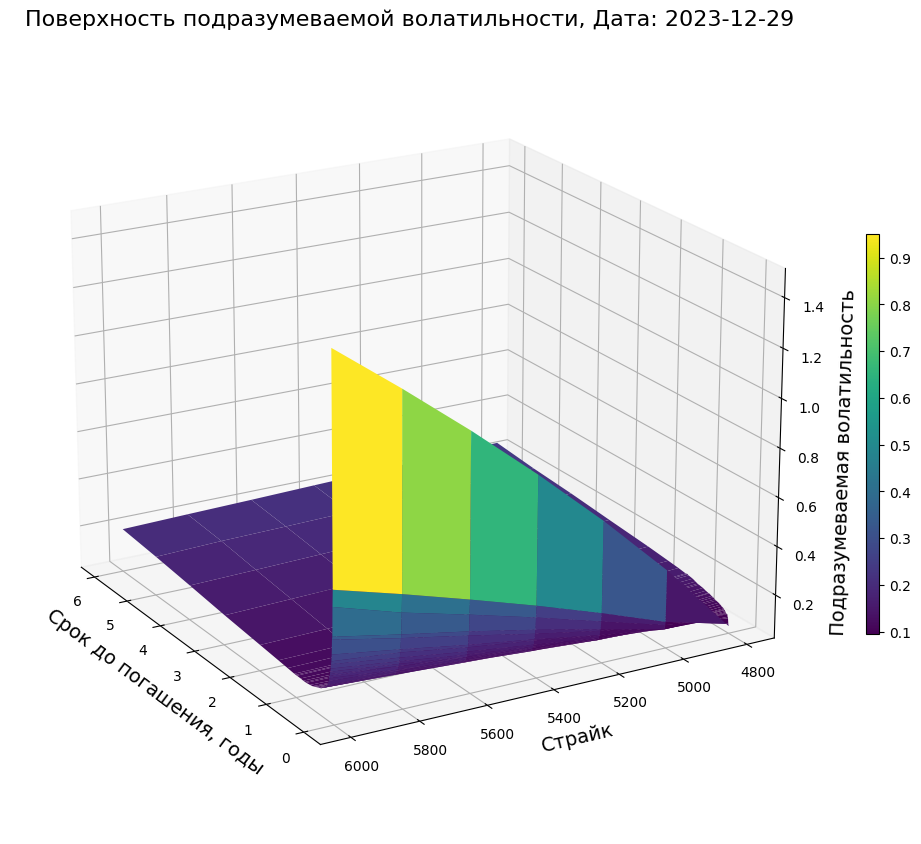

In [ ]:
# Получение индексов Strike в обратном порядке
sorted_Y = np.flip(C_IV_Matrix.index.astype(float))

# Создание сетки
X, Y = np.meshgrid(C_IV_Matrix.columns.astype(float), sorted_Y)
Z = C_IV_Matrix.loc[sorted_Y].values

# Увеличение размера графика и шрифта
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Построение поверхности
surf = ax.plot_surface(X, Y, Z, cmap='viridis')

# Настройка осей и заголовка
ax.set_xlabel('Срок до погашения, годы', fontsize=14, labelpad=5)
ax.set_ylabel('Страйк', fontsize=14, labelpad=5)
ax.set_zlabel('Подразумеваемая волатильность', fontsize=14, labelpad=5)
ax.set_title('Поверхность подразумеваемой волатильности, Дата: {}'.format(selected_date.strftime('%Y-%m-%d')), fontsize=16)

# Добавление цветовой шкалы
fig.colorbar(surf, shrink=0.5, aspect=30)

# Изменение типа проекции для оси Z и поворот оси
ax.view_init(elev=20, azim=150)

# Уменьшение рамки рисунка
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

# Сохранение графика в формате SVG
plt.savefig('volatility_surface.svg', format='svg', dpi=1500)
plt.show()

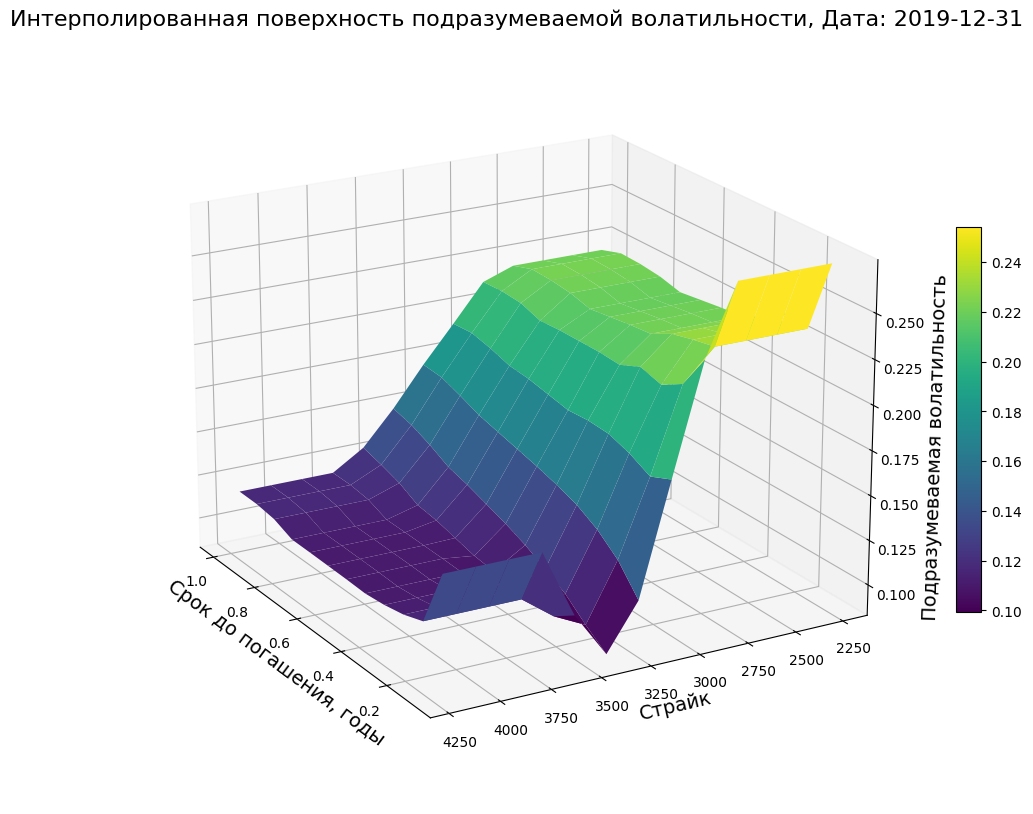

In [ ]:
# График интерполированной поверхности волатильности

X = vols_surface_interpolated.columns.astype(float)
Y = vols_surface_interpolated.index.astype(float)
Z = vols_surface_interpolated.values
X, Y = np.meshgrid(X, Y)
# Увеличение размера графика и шрифта
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')
# Построение поверхности
surf = ax.plot_surface(X, Y, Z, cmap='viridis')
# Настройка осей и заголовка
ax.set_xlabel('Срок до погашения, годы', fontsize=14, labelpad=1)
ax.set_ylabel('Страйк', fontsize=14, labelpad=1)
ax.set_zlabel('Подразумеваемая волатильность', fontsize=14, labelpad=5)
ax.set_title('Интерполированная поверхность подразумеваемой волатильности, Дата: {}'.format(selected_date.strftime('%Y-%m-%d')), fontsize=16)
# Добавление цветовой шкалы
fig.colorbar(surf, shrink=0.5, aspect=15)
# Изменение типа проекции для оси Z и поворот оси
ax.view_init(elev=20, azim=150)
# Сохранение графика в формате SVG
plt.savefig('intervolatility_surface.svg', format='svg', dpi = 1500)
plt.show()

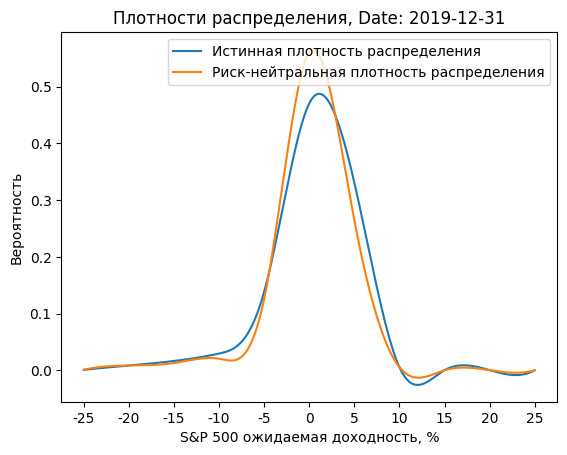

In [ ]:
# Отшкалирование массивов
F_matrix_central_row = F_matrix.iloc[central_row_index]
P_matrix_central_row = P_matrix.iloc[central_row_index]
F_scaled = F_matrix_central_row / F_matrix_central_row.sum()
P_scaled = P_matrix_central_row / P_matrix_central_row.sum()

# Создание функций интерполяции
x = np.arange(len(F_scaled))
f_interp = CubicSpline(x, F_scaled)
p_interp = CubicSpline(x, P_scaled)

# Интерполяция данных
x_interp = np.linspace(0, len(F_scaled) - 1, 1000)
F_smoothed = f_interp(x_interp)
P_smoothed = p_interp(x_interp)

# Построение графика
plt.plot(x_interp, F_smoothed, label='Истинная плотность распределения')
plt.plot(x_interp, P_smoothed, label='Риск-нейтральная плотность распределения')
plt.xlabel('S&P 500 ожидаемая доходность, %')
plt.ylabel('Вероятность')
plt.title('Плотности распределения, Date: {}'.format(selected_date.strftime('%Y-%m-%d')))
numeric_columns = pd.to_numeric(P_matrix.columns)
plt.xticks(np.linspace(0, len(F_matrix_central_row) - 1, len(F_matrix_central_row)), [int(val) for val in numeric_columns])
plt.grid(False)
plt.legend()

# Сохранение графика в формате SVG
plt.savefig('recovered_distribution.svg', format='svg', dpi = 1500)
plt.show()

In [ ]:
# Вычисление площади под кривой для графика Recovered distribution
area_recovered = trapz(F_smoothed, x_interp)
print("Площадь под кривой для графика Recovered distribution:", area_recovered)

# Вычисление площади под кривой для графика Risk neutral distribution
area_risk_neutral = trapz(P_smoothed, x_interp)
print("Площадь под кривой для графика Risk neutral distribution:", area_risk_neutral)

Площадь под кривой для графика Recovered distribution: 0.9965862365093868
Площадь под кривой для графика Risk neutral distribution: 0.9991557390045082


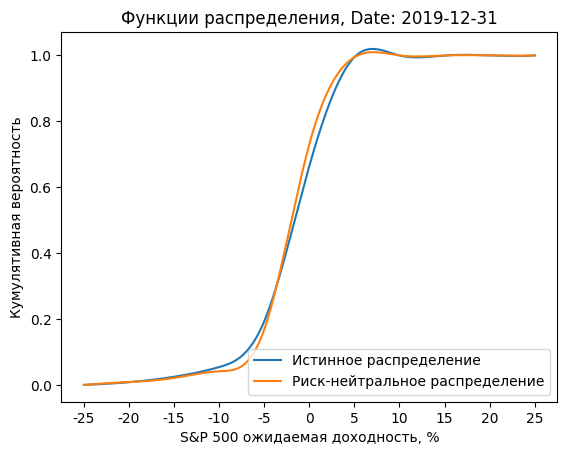

In [ ]:
# Отшкалирование массивов
F_matrix_central_row = F_matrix.iloc[central_row_index]
P_matrix_central_row = P_matrix.iloc[central_row_index]
F_scaled = F_matrix_central_row / F_matrix_central_row.sum()
P_scaled = P_matrix_central_row / P_matrix_central_row.sum()

# Создание функций интерполяции
x = np.arange(len(F_scaled))
f_interp = CubicSpline(x, F_scaled.cumsum())  # Используйте cumsum() для кумулятивной суммы
p_interp = CubicSpline(x, P_scaled.cumsum())  # Используйте cumsum() для кумулятивной суммы

# Интерполяция данных
x_interp = np.linspace(0, len(F_scaled) - 1, 1000)
F_smoothed = f_interp(x_interp)
P_smoothed = p_interp(x_interp)

# Построение графика
plt.plot(x_interp, F_smoothed, label='Истинное распределение')
plt.plot(x_interp, P_smoothed, label='Риск-нейтральное распределение')
plt.xlabel('S&P 500 ожидаемая доходность, %')
plt.ylabel('Кумулятивная вероятность')  # Измените подпись оси Y
plt.title('Функции распределения, Date: {}'.format(selected_date.strftime('%Y-%m-%d')))  # Измените заголовок
numeric_columns = pd.to_numeric(P_matrix.columns)
plt.xticks(np.linspace(0, len(F_matrix_central_row) - 1, len(F_matrix_central_row)), [int(val) for val in numeric_columns])
plt.grid(False)
plt.legend()

# Сохранение графика в формате SVG
plt.savefig('cumulative_distribution.svg', format='svg', dpi=1500)

plt.show()

# Обработка


In [ ]:
import pandas as pd
file_path = '/content/drive/My Drive/Диссертация/recovered_data_v5.csv'

# Загрузка данных из CSV-файла в DataFrame
recovered_data = pd.read_csv(file_path, index_col='Unnamed: 0', parse_dates=True)
recovered_data

,risk_neutral_mean_sp_500,risk_neutral_std_sp_500,risk_neutral_skewness_sp_500,risk_neutral_kurtosis_sp_500,recovered_mean_sp_500,recovered_std_sp_500,recovered_skewness_sp_500,recovered_kurtosis_sp_500,mean_error_percentage
2010-01-29,0.003152,0.043213,0.297726,0.866346,0.005284,0.057773,0.118273,-0.905572,32.472632
2010-02-26,0.003228,0.055619,-0.770113,1.055594,0.010803,0.078837,-0.781170,-0.932288,27.049731
2010-03-31,0.003225,0.051762,-0.969400,2.253442,0.009954,0.073268,-0.914011,-0.334561,30.433383
2010-04-30,0.003302,0.061246,-0.938244,1.589992,0.008913,0.088221,-0.815761,-0.808881,25.856744
2010-05-28,0.004070,0.081533,-0.872101,0.804742,0.045380,0.138420,-1.071221,-1.260420,19.302220
...,...,...,...,...,...,...,...,...,...
2023-05-31,0.004618,0.046225,-0.979497,1.977736,0.011908,0.064906,-0.967282,-0.317318,34.134371
2023-06-30,0.005064,0.039700,-1.017985,4.897572,0.012481,0.054958,-1.133567,1.552580,39.969879
2023-07-31,0.003411,0.036190,0.004216,0.090565,0.003801,0.057768,-0.093885,-1.903524,38.424075
2023-08-31,0.003517,0.038855,-0.368083,0.594062,0.010883,0.052562,-0.584942,-0.975083,38.097208


[*********************100%%**********************]  1 of 1 completed


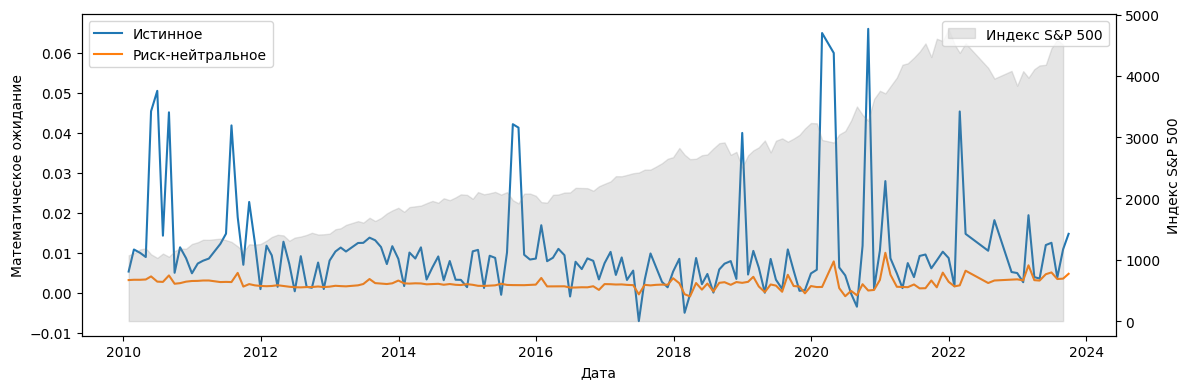

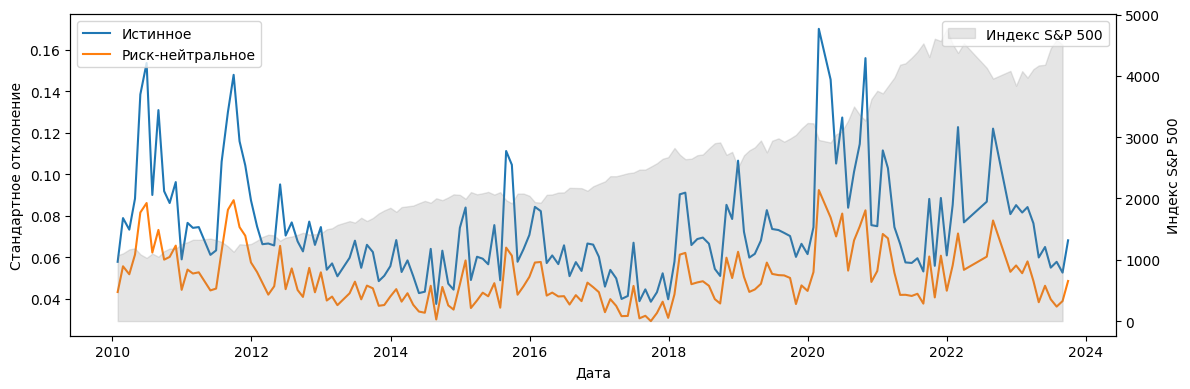

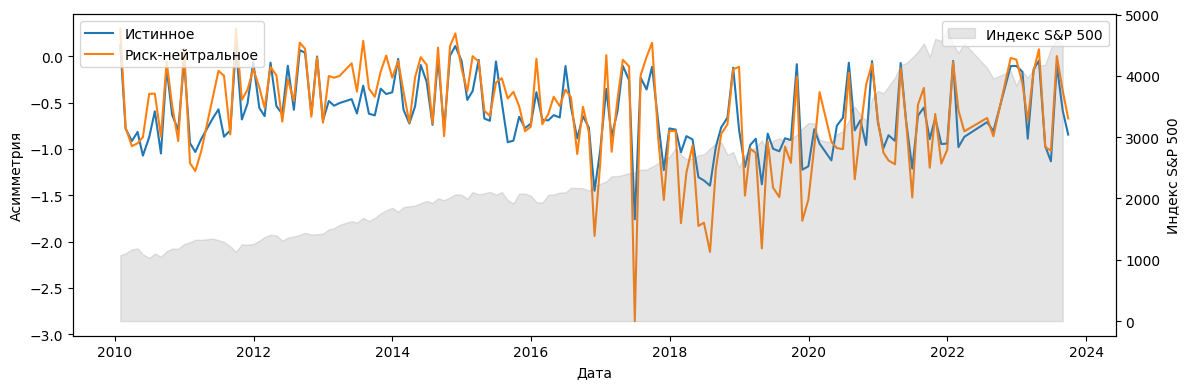

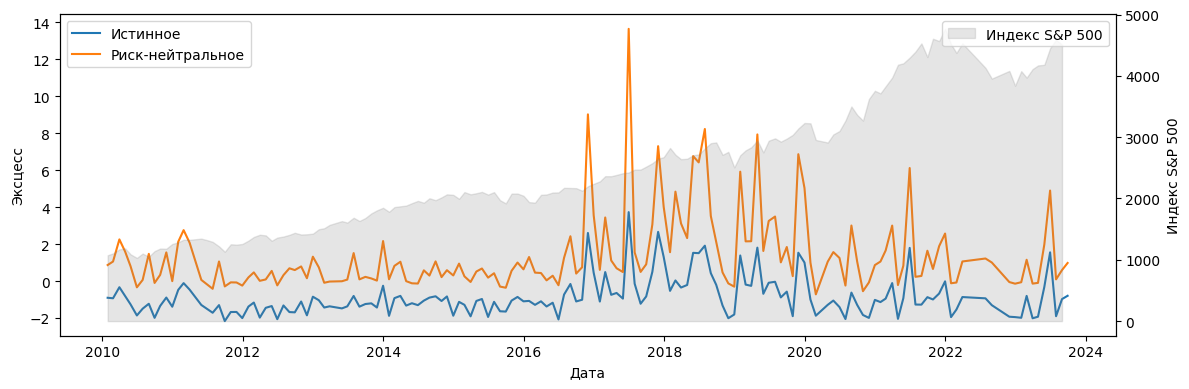

In [ ]:
# Графики по sp500 серым фоном

# Очистка выбросов по 'recovered_mean_sp_500' и 'recovered_std_sp_500'
recovered_data_cleaned = recovered_data.copy()
threshold = 3 # Порог выбросов 3 ст откл
mean_column = 'recovered_mean_sp_500'
mean_std = recovered_data_cleaned[mean_column].std()
mean_mean = recovered_data_cleaned[mean_column].mean()
recovered_data_cleaned = recovered_data_cleaned[abs(recovered_data_cleaned[mean_column] - mean_mean) < threshold * mean_std]
std_column = 'recovered_std_sp_500'
std_std = recovered_data_cleaned[std_column].std()
std_mean = recovered_data_cleaned[std_column].mean()
recovered_data_cleaned = recovered_data_cleaned[abs(recovered_data_cleaned[std_column] - std_mean) < threshold * std_std]

# Загрузка данных S&P 500
sp500_data = yf.download('^GSPC', start=recovered_data_cleaned.index.min(), end=recovered_data_cleaned.index.max())
# Подготовка данных S&P 500 для наложения на график
sp500_data = sp500_data.reindex(recovered_data_cleaned.index)

# Построение графиков для каждой пары столбцов
for i, (columns_pair, ylabel) in enumerate([(('recovered_mean_sp_500', 'risk_neutral_mean_sp_500'), 'Математическое ожидание'),
                                            (('recovered_std_sp_500', 'risk_neutral_std_sp_500'), 'Стандартное отклонение'),
                                            (('recovered_skewness_sp_500', 'risk_neutral_skewness_sp_500'), 'Асимметрия'),
                                            (('recovered_kurtosis_sp_500', 'risk_neutral_kurtosis_sp_500'), 'Эксцесс')]):
    # Создание нового графика
    fig, ax1 = plt.subplots(figsize=(12, 4))

    # График для каждой пары столбцов
    for column, label in zip(columns_pair, ['Истинное', 'Риск-нейтральное']):
        ax1.plot(recovered_data_cleaned.index, recovered_data_cleaned[column], label=label)

    # Наложение серого фона на задний план
    ax2 = ax1.twinx()
    ax2.fill_between(sp500_data.index, sp500_data['Adj Close'], color='gray', alpha=0.2, label='Индекс S&P 500')

    ax1.set_xlabel('Дата')
    ax1.set_ylabel(ylabel)
    ax2.set_ylabel('Индекс S&P 500')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    fig.tight_layout()

    # Сохранение графика в векторном формате SVG
    plt.savefig(f'график_{i+1}.svg', format='svg', dpi = 1500)
    plt.show()

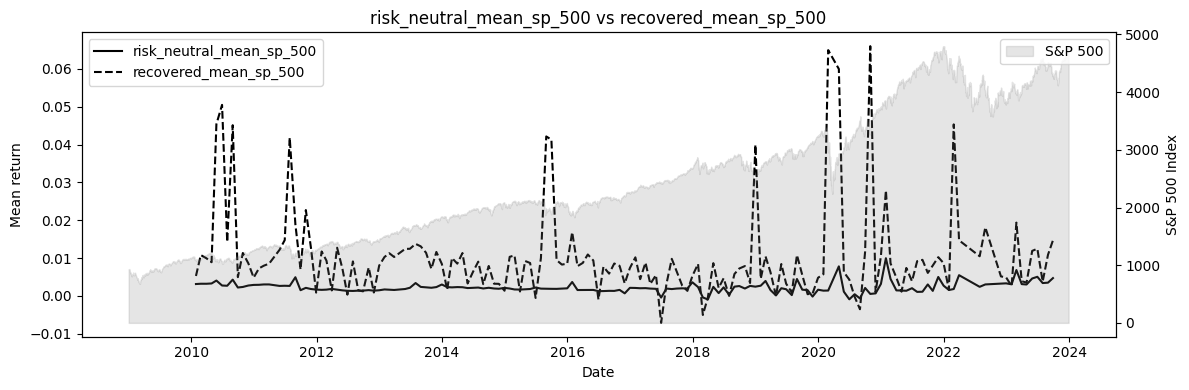

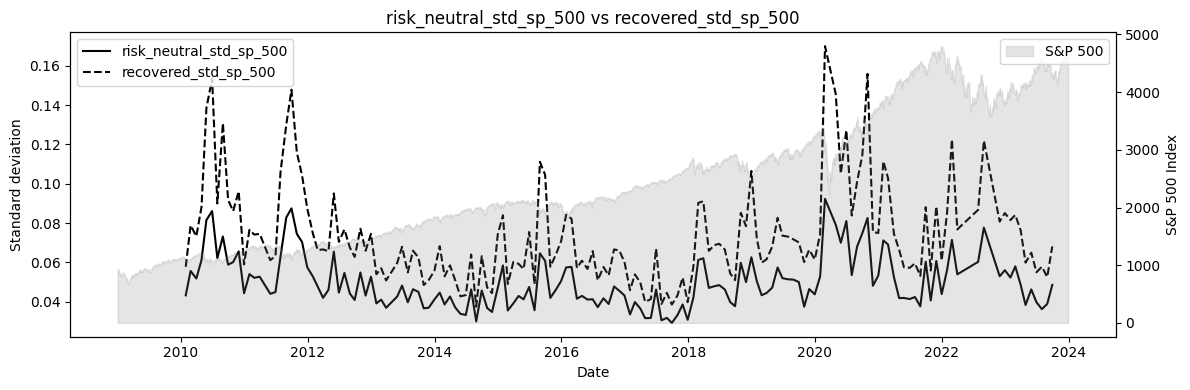

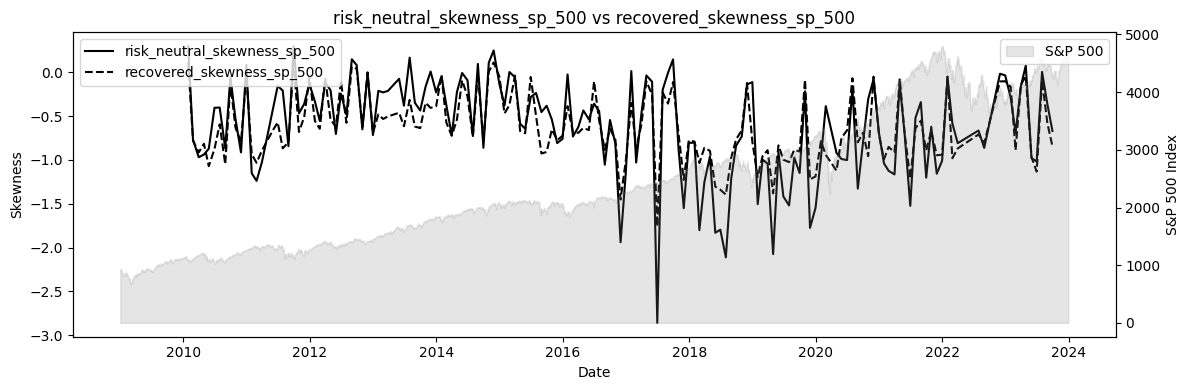

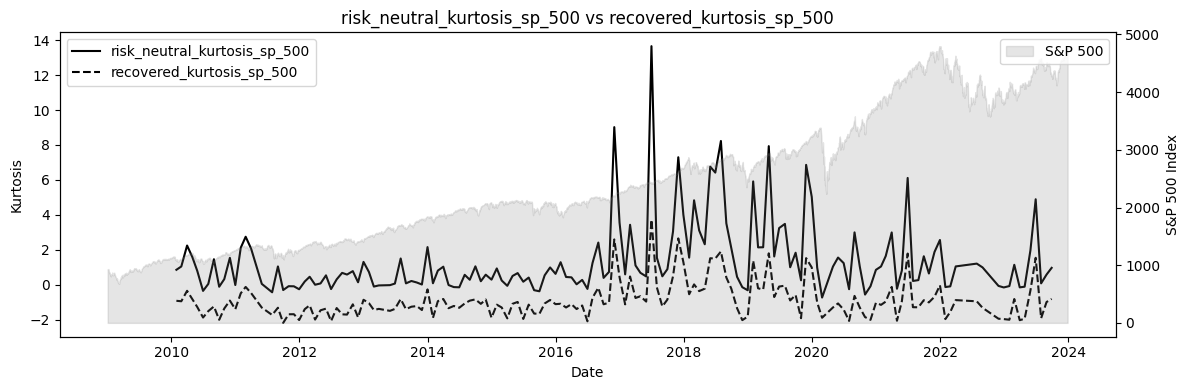

In [ ]:
# все рисунки в чб

# for i, (columns_pair, ylabel) in enumerate([(('risk_neutral_mean_sp_500', 'recovered_mean_sp_500'), 'Mean return'),
#                                             (('risk_neutral_std_sp_500', 'recovered_std_sp_500'), 'Standard deviation'),
#                                             (('risk_neutral_skewness_sp_500', 'recovered_skewness_sp_500'), 'Skewness'),
#                                             (('risk_neutral_kurtosis_sp_500', 'recovered_kurtosis_sp_500'), 'Kurtosis')]):
#     # Создание нового графика
#     fig, ax1 = plt.subplots(figsize=(12, 4))

#     # График для каждой пары столбцов
#     for j, column in enumerate(columns_pair):
#         if j == 0:
#             ax1.plot(recovered_data_cleaned.index, recovered_data_cleaned[column], label=column, color='black')
#         else:
#             ax1.plot(recovered_data_cleaned.index, recovered_data_cleaned[column], label=column, linestyle='--', color='black')

#     # Наложение серого фона на задний план
#     ax2 = ax1.twinx()
#     ax2.fill_between(sp500_data.index, sp500_data['Adj Close'], color='gray', alpha=0.2, label='S&P 500')

#     ax1.set_xlabel('Date')
#     ax1.set_ylabel(ylabel)
#     ax2.set_ylabel('S&P 500 Index')
#     ax1.legend(loc='upper left')
#     ax2.legend(loc='upper right')
#     plt.title(f'{columns_pair[0]} vs {columns_pair[1]}')
#     fig.tight_layout()

#     # Сохранение графика в векторном формате SVG
#     plt.savefig(f'plot_{i+1}.svg', format='svg')
#     plt.show()

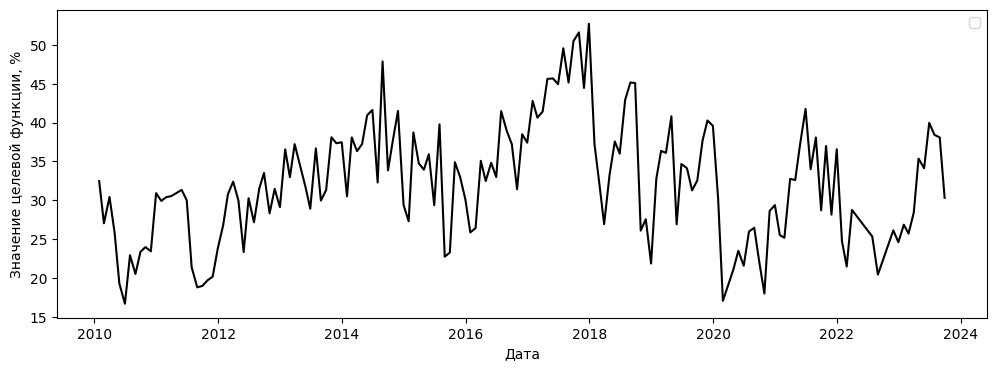

32.293611380008954


In [ ]:
# Создание графика
plt.figure(figsize=(12, 4))
plt.plot(recovered_data_cleaned.index, recovered_data_cleaned['mean_error_percentage'], label='', color='black')
plt.xlabel('Дата')
plt.ylabel('Значение целевой функции, %')
plt.legend()

# Сохранение графика в векторном формате SVG
plt.savefig('plot_5.svg', format='svg', dpi = 1500)
plt.show()

print(recovered_data_cleaned['mean_error_percentage'].mean())

# Регрессии

In [ ]:
# Расчет реализованной волатильности

# Загрузка данных по индексу S&P 500 с 2009 по 2024 год
sp500_data = yf.download('^GSPC', start='2009-01-01', end='2024-01-01')

# Определение функции для вычисления реализованной волатильности
def RV_calc(data, window):
    vols = pd.DataFrame()
    vols['Log Returns'] = data['Adj Close'].pct_change().apply(lambda x: np.log(1+x))
    vols['Squared Returns'] = vols['Log Returns']**2
    vols['Realized Volatility'] = vols['Squared Returns'].rolling(window=window).mean().apply(np.sqrt)
    return vols['Realized Volatility']

realized_volatility = RV_calc(sp500_data, window=21)
realized_volatility = realized_volatility.dropna()

[*********************100%%**********************]  1 of 1 completed


## RV(t+1) = f(REV(t))

In [ ]:
# Регрессия RV(t+1) и recovered_std(t) + с использованием стандартных ошибок Ньюи-Веста

y = realized_volatility.loc[recovered_data_cleaned.index].iloc[1:]
y = y.reset_index(drop=True)

X = recovered_data_cleaned['recovered_std_sp_500'].iloc[:-1]
X = X.reset_index(drop=True)

X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()

# Получаем оценки коэффициентов и стандартные ошибки с использованием Ньюи-Веста
nw_errors = results.get_robustcov_results(cov_type='HAC', maxlags=1)

print(nw_errors.summary())

                             OLS Regression Results                            
Dep. Variable:     Realized Volatility   R-squared:                       0.386
Model:                             OLS   Adj. R-squared:                  0.382
Method:                  Least Squares   F-statistic:                     62.88
Date:                 Sat, 24 Feb 2024   Prob (F-statistic):           4.17e-13
Time:                         20:33:17   Log-Likelihood:                 662.81
No. Observations:                  156   AIC:                            -1322.
Df Residuals:                      154   BIC:                            -1316.
Df Model:                            1                                         
Covariance Type:                   HAC                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 

In [ ]:
# Задаем переменные X и y
X = recovered_data_cleaned['recovered_std_sp_500'].iloc[:-1].values.reshape(-1, 1)
y = realized_volatility.loc[recovered_data_cleaned.index].iloc[1:].values

# Масштабируем признаки
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Создаем модель Elastic Net с использованием кросс-валидации для выбора оптимальных параметров alpha и l1_ratio
elastic_net_cv = ElasticNetCV(cv=5, random_state=42)
elastic_net_cv.fit(X_scaled, y)

# Получаем оптимальные параметры
optimal_alpha = elastic_net_cv.alpha_
optimal_l1_ratio = elastic_net_cv.l1_ratio_

# Создаем окончательную модель Elastic Net с оптимальными параметрами
elastic_net_final = ElasticNet(alpha=optimal_alpha, l1_ratio=optimal_l1_ratio)
elastic_net_final.fit(X_scaled, y)

# Получаем предсказания на всем наборе данных
y_pred = elastic_net_final.predict(X_scaled)

# Вычисляем R^2
r_squared = r2_score(y, y_pred)
print("R-squared на всем наборе данных:", r_squared)

# Вычисляем скорректированный R^2
n = len(y)
p = X.shape[1]
adjusted_r_squared = 1 - ((1 - r_squared) * (n - 1) / (n - p - 1))
print("Скорректированный R-squared на всем наборе данных:", adjusted_r_squared)

# Вычисляем AIC и BIC
n_obs = len(y)
aic = n_obs * np.log(sum((y - y_pred) ** 2) / n_obs) + 2 * p
bic = n_obs * np.log(sum((y - y_pred) ** 2) / n_obs) + p * np.log(n_obs)
print("AIC:", aic)
print("BIC:", bic)

# Получаем параметры модели
coefficients = elastic_net_final.coef_
intercept = elastic_net_final.intercept_

# Оцениваем стандартные ошибки
n = len(y)
p = X.shape[1]
residuals = y - y_pred
mse = np.sum(residuals ** 2) / (n - p - 1)
variance_covariance_matrix = mse * np.linalg.inv(np.dot(X_scaled.T, X_scaled))
standard_errors = np.sqrt(np.diag(variance_covariance_matrix))

# Выводим оценки параметров и их p-value
print("Оценки параметров:")
# Выводим коэффициенты для константы (Intercept)
print("\nIntercept:")
print(f"  Coefficient: {intercept}")
print(f"  Standard Error: {standard_errors[0]}")
# Рассчитываем статистику t и p-value для константы
t_statistic = intercept / standard_errors[0]
p_value = (1 - t.cdf(np.abs(t_statistic), n - p - 1)) * 2  # двусторонний тест
print(f"  P-value: {p_value:.3f}")

# Выводим коэффициенты для переменной
variable_name = 'REV'  # Замените на имя вашей переменной
print(f"\n{variable_name}:")
print(f"  Coefficient: {coefficients[0]}")
# Оцениваем стандартные ошибки
print(f"  Standard Error: {standard_errors[0]}")
# Рассчитываем статистику t и p-value для параметра
t_statistic = coefficients[0] / standard_errors[0]
p_value = (1 - t.cdf(np.abs(t_statistic), n - p - 1)) * 2  # двусторонний тест
print(f"  P-value: {p_value:.3f}")

R-squared на всем наборе данных: 0.3857301965431683
Скорректированный R-squared на всем наборе данных: 0.38174143158565643
AIC: -1766.3219996479809
BIC: -1763.2721436407314
Оценки параметров:

Intercept:
  Coefficient: 0.00880847410911616
  Standard Error: 0.00027847701928684367
  P-value: 0.000

REV:
  Coefficient: 0.0027357504253536584
  Standard Error: 0.00027847701928684367
  P-value: 0.000


## RV(t+1) = f(RNV(t))

In [ ]:
# Регрессия RV(t+1) и risk_neutral_std(t) + с использованием стандартных ошибок Ньюи-Веста

# Выбор только соответствующих дат в realized_volatility
y = realized_volatility.loc[recovered_data_cleaned.index].iloc[1:]
y = y.reset_index(drop=True)

# Сдвиг индекса переменной X на один временной шаг вперед
X = recovered_data_cleaned['risk_neutral_std_sp_500'].iloc[:-1]
X = X.reset_index(drop=True)

X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()

# Получаем оценки коэффициентов и стандартные ошибки с использованием Ньюи-Веста
nw_errors = results.get_robustcov_results(cov_type='HAC', maxlags=1)

print(nw_errors.summary())

                             OLS Regression Results                            
Dep. Variable:     Realized Volatility   R-squared:                       0.383
Model:                             OLS   Adj. R-squared:                  0.379
Method:                  Least Squares   F-statistic:                     70.28
Date:                 Sat, 24 Feb 2024   Prob (F-statistic):           3.04e-14
Time:                         21:03:00   Log-Likelihood:                 662.48
No. Observations:                  156   AIC:                            -1321.
Df Residuals:                      154   BIC:                            -1315.
Df Model:                            1                                         
Covariance Type:                   HAC                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const           

In [ ]:
# Задаем переменные X и y
X = recovered_data_cleaned['risk_neutral_std_sp_500'].iloc[:-1].values.reshape(-1, 1)
y = realized_volatility.loc[recovered_data_cleaned.index].iloc[1:].values

# Масштабируем признаки
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Создаем модель Elastic Net с использованием кросс-валидации для выбора оптимальных параметров alpha и l1_ratio
elastic_net_cv = ElasticNetCV(cv=5, random_state=42)
elastic_net_cv.fit(X_scaled, y)

# Получаем оптимальные параметры
optimal_alpha = elastic_net_cv.alpha_
optimal_l1_ratio = elastic_net_cv.l1_ratio_

# Создаем окончательную модель Elastic Net с оптимальными параметрами
elastic_net_final = ElasticNet(alpha=optimal_alpha, l1_ratio=optimal_l1_ratio)
elastic_net_final.fit(X_scaled, y)

# Получаем предсказания на всем наборе данных
y_pred = elastic_net_final.predict(X_scaled)

# Вычисляем R^2
r_squared = r2_score(y, y_pred)
print("R-squared на всем наборе данных:", r_squared)

# Вычисляем скорректированный R^2
n = len(y)
p = X.shape[1]
adjusted_r_squared = 1 - ((1 - r_squared) * (n - 1) / (n - p - 1))
print("Скорректированный R-squared на всем наборе данных:", adjusted_r_squared)

# Вычисляем AIC и BIC
n_obs = len(y)
aic = n_obs * np.log(sum((y - y_pred) ** 2) / n_obs) + 2 * p
bic = n_obs * np.log(sum((y - y_pred) ** 2) / n_obs) + p * np.log(n_obs)
print("AIC:", aic)
print("BIC:", bic)

# Получаем параметры модели
coefficients = elastic_net_final.coef_
intercept = elastic_net_final.intercept_

# Оцениваем стандартные ошибки
n = len(y)
p = X.shape[1]
residuals = y - y_pred
mse = np.sum(residuals ** 2) / (n - p - 1)
variance_covariance_matrix = mse * np.linalg.inv(np.dot(X_scaled.T, X_scaled))
standard_errors = np.sqrt(np.diag(variance_covariance_matrix))

# Выводим оценки параметров и их p-value
print("Оценки параметров:")
# Выводим коэффициенты для константы (Intercept)
print("\nIntercept:")
print(f"  Coefficient: {intercept}")
print(f"  Standard Error: {standard_errors[0]}")
# Рассчитываем статистику t и p-value для константы
t_statistic = intercept / standard_errors[0]
p_value = (1 - t.cdf(np.abs(t_statistic), n - p - 1)) * 2  # двусторонний тест
print(f"  P-value: {p_value:.3f}")

# Выводим коэффициенты для переменной
variable_name = 'RNV'  # Замените на имя вашей переменной
print(f"\n{variable_name}:")
print(f"  Coefficient: {coefficients[0]}")
# Оцениваем стандартные ошибки
print(f"  Standard Error: {standard_errors[0]}")
# Рассчитываем статистику t и p-value для параметра
t_statistic = coefficients[0] / standard_errors[0]
p_value = (1 - t.cdf(np.abs(t_statistic), n - p - 1)) * 2  # двусторонний тест
print(f"  P-value: {p_value:.3f}")

R-squared на всем наборе данных: 0.3831593813707088
Скорректированный R-squared на всем наборе данных: 0.37915392280818094
AIC: -1765.6704776680708
BIC: -1762.6206216608214
Оценки параметров:

Intercept:
  Coefficient: 0.008808474109116157
  Standard Error: 0.0002790591457838621
  P-value: 0.000

RNV:
  Coefficient: 0.0027266185926131505
  Standard Error: 0.0002790591457838621
  P-value: 0.000


## RV(t+1) = f(REV(t) - RNV(t))

In [ ]:
# RVt+1 = REVt - RNVt
y = realized_volatility.loc[recovered_data_cleaned.index].iloc[1:]
y = y.reset_index(drop=True)

X = recovered_data_cleaned['recovered_std_sp_500'].iloc[:-1] - recovered_data_cleaned['risk_neutral_std_sp_500'].iloc[:-1]
X = X.reset_index(drop=True)

X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()

nw_errors = results.get_robustcov_results(cov_type='HAC', maxlags=1)

print(nw_errors.summary())

                             OLS Regression Results                            
Dep. Variable:     Realized Volatility   R-squared:                       0.355
Model:                             OLS   Adj. R-squared:                  0.351
Method:                  Least Squares   F-statistic:                     45.83
Date:                 Sat, 24 Feb 2024   Prob (F-statistic):           2.55e-10
Time:                         21:06:51   Log-Likelihood:                 658.96
No. Observations:                  156   AIC:                            -1314.
Df Residuals:                      154   BIC:                            -1308.
Df Model:                            1                                         
Covariance Type:                   HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0039      0.001      5.86

In [ ]:
# RVt+1 = REVt - RNVt   Elastic net

# Задаем переменные X и y
X = (recovered_data_cleaned['recovered_std_sp_500'].iloc[:-1] - recovered_data_cleaned['risk_neutral_std_sp_500'].iloc[:-1]).values.reshape(-1, 1)
y = realized_volatility.loc[recovered_data_cleaned.index].iloc[1:].values

# Масштабируем признаки
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Создаем модель Elastic Net с использованием кросс-валидации для выбора оптимальных параметров alpha и l1_ratio
elastic_net_cv = ElasticNetCV(cv=5, random_state=42)
elastic_net_cv.fit(X_scaled, y)

# Получаем оптимальные параметры
optimal_alpha = elastic_net_cv.alpha_
optimal_l1_ratio = elastic_net_cv.l1_ratio_

# Создаем окончательную модель Elastic Net с оптимальными параметрами
elastic_net_final = ElasticNet(alpha=optimal_alpha, l1_ratio=optimal_l1_ratio)
elastic_net_final.fit(X_scaled, y)

# Получаем предсказания на всем наборе данных
y_pred = elastic_net_final.predict(X_scaled)

# Вычисляем R^2
r_squared = r2_score(y, y_pred)
print("R-squared на всем наборе данных:", r_squared)

# Вычисляем скорректированный R^2
n = len(y)
p = X.shape[1]
adjusted_r_squared = 1 - ((1 - r_squared) * (n - 1) / (n - p - 1))
print("Скорректированный R-squared на всем наборе данных:", adjusted_r_squared)

# Вычисляем AIC и BIC
n_obs = len(y)
aic = n_obs * np.log(sum((y - y_pred) ** 2) / n_obs) + 2 * p
bic = n_obs * np.log(sum((y - y_pred) ** 2) / n_obs) + p * np.log(n_obs)
print("AIC:", aic)
print("BIC:", bic)

# Получаем параметры модели
coefficients = elastic_net_final.coef_
intercept = elastic_net_final.intercept_

# Оцениваем стандартные ошибки
n = len(y)
p = X.shape[1]
residuals = y - y_pred
mse = np.sum(residuals ** 2) / (n - p - 1)
variance_covariance_matrix = mse * np.linalg.inv(np.dot(X_scaled.T, X_scaled))
standard_errors = np.sqrt(np.diag(variance_covariance_matrix))

# Выводим оценки параметров и их p-value
print("Оценки параметров:")
# Выводим коэффициенты для константы (Intercept)
print("\nIntercept:")
print(f"  Coefficient: {intercept}")
print(f"  Standard Error: {standard_errors[0]}")
# Рассчитываем статистику t и p-value для константы
t_statistic = intercept / standard_errors[0]
p_value = (1 - t.cdf(np.abs(t_statistic), n - p - 1)) * 2  # двусторонний тест
print(f"  P-value: {p_value:.3f}")

# Выводим коэффициенты для переменной
variable_name = 'REV-RNV'  # Замените на имя вашей переменной
print(f"\n{variable_name}:")
print(f"  Coefficient: {coefficients[0]}")
# Оцениваем стандартные ошибки
print(f"  Standard Error: {standard_errors[0]}")
# Рассчитываем статистику t и p-value для параметра
t_statistic = coefficients[0] / standard_errors[0]
p_value = (1 - t.cdf(np.abs(t_statistic), n - p - 1)) * 2  # двусторонний тест
print(f"  P-value: {p_value:.3f}")

R-squared на всем наборе данных: 0.35470465734982537
Скорректированный R-squared на всем наборе данных: 0.35051442785209697
AIC: -1758.6352780131242
BIC: -1755.5854220058748
Оценки параметров:

Intercept:
  Coefficient: 0.008808474109116159
  Standard Error: 0.0002854230507512677
  P-value: 0.000

REV-RNV:
  Coefficient: 0.002623421964709021
  Standard Error: 0.0002854230507512677
  P-value: 0.000


## RV(t+1) = f(REV(t); (REV(t) - RNV(t)))

In [ ]:
# RVt+1 = REVt + (REVt - RNVt)

y = realized_volatility.loc[recovered_data_cleaned.index].iloc[1:]
y = y.reset_index(drop=True)

X1 = recovered_data_cleaned['recovered_std_sp_500'].iloc[:-1]
X1 = X1.reset_index(drop=True)

X2 = recovered_data_cleaned['recovered_std_sp_500'].iloc[:-1] - recovered_data_cleaned['risk_neutral_std_sp_500'].iloc[:-1]
X2 = X2.reset_index(drop=True)

X = sm.add_constant(pd.concat([X1, X2], axis = 1, keys = ['REV', 'REV-RNV']))

model = sm.OLS(y, X)
results = model.fit()

nw_errors = results.get_robustcov_results(cov_type='HAC', maxlags=1)

print(nw_errors.summary())

                             OLS Regression Results                            
Dep. Variable:     Realized Volatility   R-squared:                       0.389
Model:                             OLS   Adj. R-squared:                  0.381
Method:                  Least Squares   F-statistic:                     39.19
Date:                 Sat, 24 Feb 2024   Prob (F-statistic):           1.81e-14
Time:                         21:11:30   Log-Likelihood:                 663.17
No. Observations:                  156   AIC:                            -1320.
Df Residuals:                      153   BIC:                            -1311.
Df Model:                            2                                         
Covariance Type:                   HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003      0.001     -0.20

In [ ]:
from sklearn.linear_model import ElasticNetCV, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from scipy.stats import t
import numpy as np

# Задаем переменные X и y
X1 = recovered_data_cleaned['recovered_std_sp_500'].iloc[:-1].values.reshape(-1, 1)
X2 = (recovered_data_cleaned['recovered_std_sp_500'].iloc[:-1] -
      recovered_data_cleaned['risk_neutral_std_sp_500'].iloc[:-1]).values.reshape(-1, 1)

# Объединяем регрессоры
X = np.concatenate((X1, X2), axis=1)
y = realized_volatility.loc[recovered_data_cleaned.index].iloc[1:].values

# Масштабируем признаки
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Создаем модель Elastic Net с использованием кросс-валидации для выбора оптимальных параметров alpha и l1_ratio
elastic_net_cv = ElasticNetCV(cv=5, random_state=42)
elastic_net_cv.fit(X_scaled, y)

# Получаем оптимальные параметры
optimal_alpha = elastic_net_cv.alpha_
optimal_l1_ratio = elastic_net_cv.l1_ratio_

# Создаем окончательную модель Elastic Net с оптимальными параметрами
elastic_net_final = ElasticNet(alpha=optimal_alpha, l1_ratio=optimal_l1_ratio)
elastic_net_final.fit(X_scaled, y)

# Получаем предсказания на всем наборе данных
y_pred = elastic_net_final.predict(X_scaled)

# Вычисляем R^2
r_squared = r2_score(y, y_pred)
print("R-squared на всем наборе данных:", r_squared)

# Вычисляем скорректированный R^2
n = len(y)
p = X.shape[1]
adjusted_r_squared = 1 - ((1 - r_squared) * (n - 1) / (n - p - 1))
print("Скорректированный R-squared на всем наборе данных:", adjusted_r_squared)

# Вычисляем AIC и BIC
n_obs = len(y)
aic = n_obs * np.log(sum((y - y_pred) ** 2) / n_obs) + 2 * p
bic = n_obs * np.log(sum((y - y_pred) ** 2) / n_obs) + p * np.log(n_obs)
print("AIC:", aic)
print("BIC:", bic)

# Получаем параметры модели
coefficients = elastic_net_final.coef_
intercept = elastic_net_final.intercept_

# Оцениваем стандартные ошибки
n = len(y)
p = X.shape[1]
residuals = y - y_pred
mse = np.sum(residuals ** 2) / (n - p - 1)
variance_covariance_matrix = mse * np.linalg.inv(np.dot(X_scaled.T, X_scaled))
standard_errors = np.sqrt(np.diag(variance_covariance_matrix))

# Выводим оценки параметров и их p-value
print("Оценки параметров:")
# Выводим коэффициенты для константы (Intercept)
print("\nIntercept:")
print(f"  Coefficient: {intercept}")
print(f"  Standard Error: {standard_errors[0]}")
# Рассчитываем статистику t и p-value для константы
t_statistic = intercept / standard_errors[0]
p_value = (1 - t.cdf(np.abs(t_statistic), n - p - 1)) * 2  # двусторонний тест
print(f"  P-value: {p_value:.3f}")

# Выводим коэффициенты для переменных
for idx, variable_name in enumerate(['REV', 'REV-RNV']):
    coefficient_rounded = '{:.3f}'.format(coefficients[idx])  # Округляем коэффициент до трех знаков
    standard_error_rounded = round(standard_errors[idx], 3)  # Округляем стандартную ошибку до трех знаков
    print(f"\n{variable_name}:")
    print(f"  Coefficient: {coefficient_rounded}")
    # Оцениваем стандартные ошибки
    print(f"  Standard Error: {standard_error_rounded}")
    # Рассчитываем статистику t и p-value для параметра
    t_statistic = coefficients[idx] / standard_errors[idx]
    p_value = (1 - t.cdf(np.abs(t_statistic), n - p - 1)) * 2  # двусторонний тест
    print(f"  P-value: {p_value:.3f}")

R-squared на всем наборе данных: 0.3856526631141214
Скорректированный R-squared на всем наборе данных: 0.37762197897182237
AIC: -1764.3023104957622
BIC: -1758.202598481263
Оценки параметров:

Intercept:
  Coefficient: 0.00880847410911616
  Standard Error: 0.0013179156837685151
  P-value: 0.000

REV:
  Coefficient: 0.003
  Standard Error: 0.001
  P-value: 0.042

REV-RNV:
  Coefficient: -0.000
  Standard Error: 0.001
  P-value: 1.000


## RV(t+1) = f(RNV(t); (REV(t) - RNV(t)))

In [ ]:
# RVt+1 = RNVt + (REVt - RNVt)

y = realized_volatility.loc[recovered_data_cleaned.index].iloc[1:]
y = y.reset_index(drop=True)

X1 = recovered_data_cleaned['risk_neutral_std_sp_500'].iloc[:-1]
X1 = X1.reset_index(drop=True)

X2 = recovered_data_cleaned['recovered_std_sp_500'].iloc[:-1] - recovered_data_cleaned['risk_neutral_std_sp_500'].iloc[:-1]
X2 = X2.reset_index(drop=True)

X = sm.add_constant(pd.concat([X1, X2], axis = 1, keys = ['RNV', 'REV-RNV']))

model = sm.OLS(y, X)
results = model.fit()

nw_errors = results.get_robustcov_results(cov_type='HAC', maxlags=1)

print(nw_errors.summary())

                             OLS Regression Results                            
Dep. Variable:     Realized Volatility   R-squared:                       0.389
Model:                             OLS   Adj. R-squared:                  0.381
Method:                  Least Squares   F-statistic:                     39.19
Date:                 Sat, 24 Feb 2024   Prob (F-statistic):           1.81e-14
Time:                         21:18:16   Log-Likelihood:                 663.17
No. Observations:                  156   AIC:                            -1320.
Df Residuals:                      153   BIC:                            -1311.
Df Model:                            2                                         
Covariance Type:                   HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003      0.001     -0.20

In [ ]:
# Задаем переменные X и y
X1 = recovered_data_cleaned['risk_neutral_std_sp_500'].iloc[:-1].values.reshape(-1, 1)
X2 = (recovered_data_cleaned['recovered_std_sp_500'].iloc[:-1] -
      recovered_data_cleaned['risk_neutral_std_sp_500'].iloc[:-1]).values.reshape(-1, 1)

# Объединяем регрессоры
X = np.concatenate((X1, X2), axis=1)
y = realized_volatility.loc[recovered_data_cleaned.index].iloc[1:].values

# Масштабируем признаки
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Создаем модель Elastic Net с использованием кросс-валидации для выбора оптимальных параметров alpha и l1_ratio
elastic_net_cv = ElasticNetCV(cv=5, random_state=42)
elastic_net_cv.fit(X_scaled, y)

# Получаем оптимальные параметры
optimal_alpha = elastic_net_cv.alpha_
optimal_l1_ratio = elastic_net_cv.l1_ratio_

# Создаем окончательную модель Elastic Net с оптимальными параметрами
elastic_net_final = ElasticNet(alpha=optimal_alpha, l1_ratio=optimal_l1_ratio)
elastic_net_final.fit(X_scaled, y)

# Получаем предсказания на всем наборе данных
y_pred = elastic_net_final.predict(X_scaled)

# Вычисляем R^2
r_squared = r2_score(y, y_pred)
print("R-squared на всем наборе данных:", r_squared)

# Вычисляем скорректированный R^2
n = len(y)
p = X.shape[1]
adjusted_r_squared = 1 - ((1 - r_squared) * (n - 1) / (n - p - 1))
print("Скорректированный R-squared на всем наборе данных:", adjusted_r_squared)

# Вычисляем AIC и BIC
n_obs = len(y)
aic = n_obs * np.log(sum((y - y_pred) ** 2) / n_obs) + 2 * p
bic = n_obs * np.log(sum((y - y_pred) ** 2) / n_obs) + p * np.log(n_obs)
print("AIC:", aic)
print("BIC:", bic)

# Получаем параметры модели
coefficients = elastic_net_final.coef_
intercept = elastic_net_final.intercept_

# Оцениваем стандартные ошибки
n = len(y)
p = X.shape[1]
residuals = y - y_pred
mse = np.sum(residuals ** 2) / (n - p - 1)
variance_covariance_matrix = mse * np.linalg.inv(np.dot(X_scaled.T, X_scaled))
standard_errors = np.sqrt(np.diag(variance_covariance_matrix))

# Выводим оценки параметров и их p-value
print("Оценки параметров:")
# Выводим коэффициенты для константы (Intercept)
print("\nIntercept:")
print(f"  Coefficient: {intercept}")
print(f"  Standard Error: {standard_errors[0]}")
# Рассчитываем статистику t и p-value для константы
t_statistic = intercept / standard_errors[0]
p_value = (1 - t.cdf(np.abs(t_statistic), n - p - 1)) * 2  # двусторонний тест
print(f"  P-value: {p_value:.3f}")

# Выводим коэффициенты для переменных
for idx, variable_name in enumerate(['RNV', 'REV-RNV']):
    coefficient_rounded = '{:.3f}'.format(coefficients[idx])  # Округляем коэффициент до трех знаков
    standard_error_rounded = round(standard_errors[idx], 3)  # Округляем стандартную ошибку до трех знаков
    print(f"\n{variable_name}:")
    print(f"  Coefficient: {coefficient_rounded}")
    # Оцениваем стандартные ошибки
    print(f"  Standard Error: {standard_error_rounded}")
    # Рассчитываем статистику t и p-value для параметра
    t_statistic = coefficients[idx] / standard_errors[idx]
    p_value = (1 - t.cdf(np.abs(t_statistic), n - p - 1)) * 2  # двусторонний тест
    print(f"  P-value: {p_value:.3f}")

# Создаем модель Elastic Net с использованием кросс-валидации для выбора оптимальных параметров alpha и l1_ratio
elastic_net_cv = ElasticNetCV(cv=5, random_state=42)
elastic_net_cv.fit(X_scaled, y)

# Получаем оптимальные параметры
optimal_alpha = elastic_net_cv.alpha_
optimal_l1_ratio = elastic_net_cv.l1_ratio_
print("Оптимальное значение alpha:", optimal_alpha)
print("Оптимальное значение l1_ratio:", optimal_l1_ratio)

R-squared на всем наборе данных: 0.38861320580581993
Скорректированный R-squared на всем наборе данных: 0.3806212215679875
AIC: -1765.05589244522
BIC: -1758.956180430721
Оценки параметров:

Intercept:
  Coefficient: 0.00880847410911616
  Standard Error: 0.000685699156161372
  P-value: 0.000

RNV:
  Coefficient: 0.002
  Standard Error: 0.001
  P-value: 0.004

REV-RNV:
  Coefficient: 0.001
  Standard Error: 0.001
  P-value: 0.246
Оптимальное значение alpha: 5.458710779828434e-06
Оптимальное значение l1_ratio: 0.5
